# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import librosa
import librosa.display
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

# 1. 데이터 처리 및 분류

In [2]:
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [3]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [4]:
# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  9180
Wave data shape :  (8000,)
label :  ['off']


In [5]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [6]:
temp = []
for v in speech_data["label_vals"][:20000]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

In [7]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [8]:
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


In [9]:
spec = []
data2 = speech_data["wav_vals"][:20000]
for data in data2:
    spec.append(wav2spec(data))
    
spec = np.array(spec)
print(spec.shape)

(20000, 130, 126)


In [10]:
sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)


[[[8.16194050e-04 6.74092909e-04 7.26178812e-04 ... 1.73626075e-04
   5.22502407e-04 6.11710304e-04]
  [6.91371737e-04 2.02735711e-04 4.08702705e-04 ... 5.44946291e-04
   9.56599397e-05 6.62967213e-04]
  [8.39366985e-04 5.24092757e-04 2.64347036e-04 ... 4.49085404e-04
   7.32704648e-04 8.44199269e-04]
  ...
  [5.31582373e-05 3.30017428e-05 7.68535938e-06 ... 1.73321484e-06
   2.75917591e-06 9.60055422e-06]
  [5.97922699e-05 3.11476979e-05 3.44287992e-06 ... 1.90114349e-06
   4.18812897e-06 7.71342366e-06]
  [5.62139176e-05 2.65207109e-05 1.44721378e-06 ... 4.63945931e-08
   5.72987210e-06 9.73668102e-06]]

 [[3.59088421e-01 3.88995647e-01 4.61138427e-01 ... 3.45156848e-01
   3.43992472e-01 3.29148859e-01]
  [1.66547030e-01 1.92215249e-01 2.32634321e-01 ... 1.89030409e-01
   1.70707524e-01 1.57757029e-01]
  [1.61576606e-02 7.15047959e-03 1.42788747e-02 ... 2.69865002e-02
   6.47589518e-03 5.11605525e-03]
  ...
  [2.14495044e-03 1.02873181e-03 6.22023872e-05 ... 1.83156208e-05
   2.30646

In [11]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (18000, 130, 126)
train labels :  (18000,)
test data :  (2000, 130, 126)
test labels :  (2000,)


# 2. 하이퍼파라미터 설정

In [12]:
batch_size = 8
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel/aiffel/speech_recognition/models/wav'

# 3.데이터셋 구성

In [13]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [14]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


# 4. 2차원 Spectrogram 모델   
### 4-1. Wave classification Model

In [16]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)           

In [17]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [19]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
2242/2250 [============================>.] - ETA: 0s - loss: 1.6280 - accuracy: 0.4215
Epoch 00001: val_loss improved from inf to 1.02195, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
2250/2250 [==============================] - 9s 4ms/step - loss: 1.6260 - accuracy: 0.4224 - val_loss: 1.0219 - val_accuracy: 0.6580
Epoch 2/10
2243/2250 [============================>.] - ETA: 0s - loss: 0.9107 - accuracy: 0.6914
Epoch 00002: val_loss improved from 1.02195 to 0.63275, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
2250/2250 [==============================] - 9s 4ms/step - loss: 0.9094 - accuracy: 0.6918 - val_loss: 0.6328 - val_accuracy: 0.7875
Epoch 3/10
2244/2250 [============================>.] - ETA: 0s - loss: 0.6169 - accuracy: 0.7989
Epoch 00003: val_loss improved from 0.63275 to 0.48985, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
2250/2250 [==============================] - 9s 4ms/step - loss: 0.6166 - accu

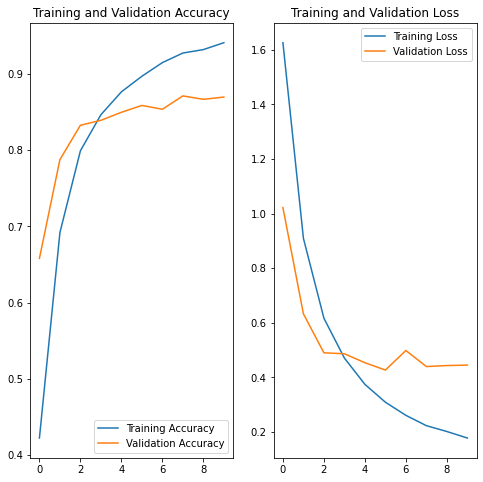

In [20]:
acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
model_wav.load_weights(checkpoint_dir)

In [22]:
results = model_wav.evaluate(test_dataset)

250/250 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.8585


In [23]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.427
accuracy value: 85.8500%


In [25]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

# ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  go


In [26]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: go


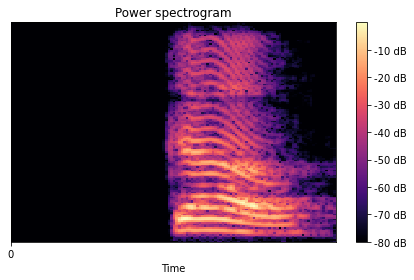

In [29]:
librosa.display.specshow(librosa.amplitude_to_db(batch_xs.reshape(130,126), ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### 4-2. Skip-Connection Model

In [30]:
input_tensor = layers.Input(shape=(130,126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
_______________________________________________________________________________________

In [31]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [32]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [33]:
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
2248/2250 [============================>.] - ETA: 0s - loss: 1.7783 - accuracy: 0.3657
Epoch 00001: val_loss improved from inf to 1.20646, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
2250/2250 [==============================] - 10s 5ms/step - loss: 1.7777 - accuracy: 0.3658 - val_loss: 1.2065 - val_accuracy: 0.5780
Epoch 2/10
2247/2250 [============================>.] - ETA: 0s - loss: 1.0877 - accuracy: 0.6253
Epoch 00002: val_loss improved from 1.20646 to 0.80865, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
2250/2250 [==============================] - 10s 5ms/step - loss: 1.0875 - accuracy: 0.6254 - val_loss: 0.8087 - val_accuracy: 0.7215
Epoch 3/10
2245/2250 [============================>.] - ETA: 0s - loss: 0.7310 - accuracy: 0.7549
Epoch 00003: val_loss improved from 0.80865 to 0.55897, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
2250/2250 [==============================] - 10s 5ms/step - l

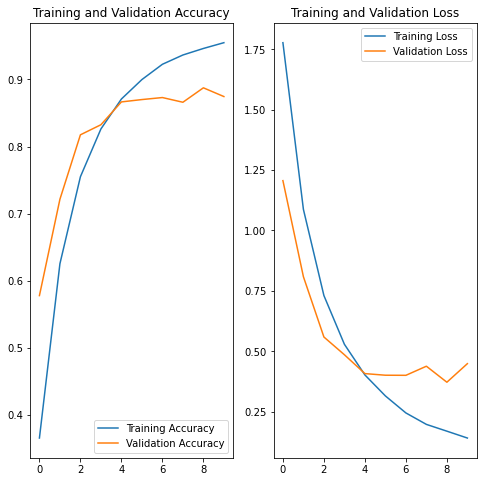

In [34]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

250/250 [==============================] - 0s 2ms/step - loss: 0.3717 - accuracy: 0.8875
loss value: 0.372
accuracy value: 88.7500%


In [36]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

label :  yes


In [37]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: yes


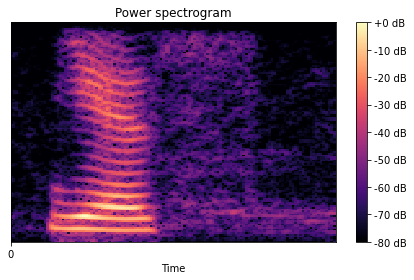

In [38]:
librosa.display.specshow(librosa.amplitude_to_db(batch_xs.reshape(130,126), ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

5. 총평
- 전체 데이터를 쓰면 OOM문제 발생으로 20000데이터로 진행하였다.    
- 2차원 데이터를 사용할때 더 나은 성능이 나오고 훈련 속도가 빨라진거 같았다.